<a href="https://colab.research.google.com/github/eloigil/fast.ai_playground/blob/main/04_mnist_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.7MB/s 
     |████████████████████████████████| 1.2MB 16.1MB/s 
     |████████████████████████████████| 194kB 36.2MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 61kB 11.5MB/s 
     |████████████████████████████████| 51kB 9.9MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/root/.fastai/data/mnist_sample')

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [ ]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
# print(threes)
# print(sevens)

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [ ]:
type(im3) #PIL is Pynthon Imaging Library

PIL.PngImagePlugin.PngImageFile

In [ ]:
# Converting it to NumPy array
array(im3)[4:10,4:10] # the 4:10 is just selecting a part of the total array

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [ ]:
# Converting it to PyTorch tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [ ]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22]) #pandas dataframe (cause it has background_gradient)
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens] #convert all sevens to tensors
three_tensors = [tensor(Image.open(o)) for o in threes] #convert all threes to tensors
len(three_tensors),len(seven_tensors)

(6131, 6265)

torch.Size([28, 28])

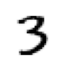

In [ ]:
show_image(three_tensors[1]) #fast.ai command to display a tensor
three_tensors[1].shape

In [ ]:
# funny note
print(type(three_tensors[1])) # python type says its a pytorch library tensor
print(three_tensors[1].type()) # type method shows the type of tensor

<class 'torch.Tensor'>
torch.ByteTensor


In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [ ]:
rank = len(stacked_threes.shape)
rank

3

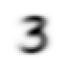

In [ ]:
mean3 = stacked_threes.mean(0) # take the mean from the first axis
show_image(mean3);

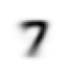

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

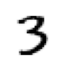

In [ ]:
a_3 = stacked_threes[1]
show_image(a_3)

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean() # L1 norm
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() # L2 norm
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

## Computing Metrics Using Broadcasting

In [ ]:
# doing the same before for the validation sets
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3) #process run once

tensor(0.1114)

In [ ]:
# but we have to do the process for the entire valiation set
valid_3_dist = mnist_distance(valid_3_tens, mean3)
print('valid_3_tens shape:', valid_3_tens.shape)
print('mean3 shape:', mean3.shape)
valid_3_dist, valid_3_dist.shape
# it returned an array of 1010 values due to Broadcasting: when it finds different shapes it acts as if mean3 was copied 1010 times

valid_3_tens shape: torch.Size([1010, 28, 28])
mean3 shape: torch.Size([28, 28])


(tensor([0.1824, 0.1252, 0.1484,  ..., 0.1245, 0.1296, 0.1113]),
 torch.Size([1010]))

In [ ]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [ ]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [ ]:
# we can broadcast the process into the entire set
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [ ]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent SGD